In [1]:
! pip install -q qiskit
! pip install -q qiskit-aer
! pip install -q qiskit-algorithms
! pip install -q qiskit-nature
! pip install -q qiskit-nature-pyscf # install the pyscf library
! pip install -q qiskit-ibm-runtime
# print(qiskit.__version__)
# print(qiskit_aer.__version__)
# print(qiskit_algorithms.__version__)
# print(qiskit_nature.__version__)
# print(qiskit_nature_pyscf.__version__)
# print(qiskit_ibm_runtime.__version__)

In [2]:
import qiskit_nature
import qiskit
import qiskit_aer
import qiskit_algorithms
import qiskit_ibm_runtime
import qiskit_nature_pyscf
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit.circuit.library import EfficientSU2
import numpy as np
import matplotlib.pyplot as plt
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_aer import  AerSimulator
# from qiskit_nature.second_q.algorithms import VQEUCCFactory
from qiskit_algorithms.optimizers import SLSQP
from qiskit_aer.primitives import Estimator
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.problems import ElectronicBasis
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.mappers import ParityMapper
from scipy.linalg import eigh
from qiskit_nature.second_q.circuit.library import HartreeFock
from scipy.linalg import expm
from qiskit.quantum_info import Statevector
from numpy import pi

# Analysis of Li atom in 10 spin orbitals:

In [3]:
mdriver = PySCFDriver(
    atom="Li 0.0 0.0 0.0",  # Specify the atom and its coordinates
    basis="sto3g",          # Define the basis set
    charge=0,                # Set the charge of the atom
    spin=1,                 # Set the spin of the atom
    unit=DistanceUnit.ANGSTROM, # Define the unit of the coordinates
)

# You can now use the driver to run a calculation
electronic_structure_problem = mdriver.run()

In [4]:
print("Spatial orbitals:", electronic_structure_problem.num_spatial_orbitals)
print("Number of up spin: ", electronic_structure_problem.num_alpha)
print("Number of down spin: ", electronic_structure_problem.num_beta)
print("\n")
print("Down spin configuration : ", electronic_structure_problem.orbital_occupations_b)
print("Down spin configuration : ",electronic_structure_problem.orbital_occupations)
print("Number of particles: ", electronic_structure_problem.num_particles)
# print(electronic_structure_problem.second_q_ops()[0])

Spatial orbitals: 5
Number of up spin:  2
Number of down spin:  1


Down spin configuration :  [1. 0. 0. 0. 0.]
Down spin configuration :  [1. 1. 0. 0. 0.]
Number of particles:  (2, 1)


In [5]:
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper

solver = GroundStateEigensolver(
    JordanWignerMapper(),
    NumPyMinimumEigensolver(),
)

result = solver.solve(electronic_structure_problem)
print(result)
print("HF energy : ", electronic_structure_problem.reference_energy)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -7.315836552851
  - computed part:      -7.315836552851
~ Nuclear repulsion energy (Hartree): 0.0
> Total ground state energy (Hartree): -7.315836552851
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 3.000 S: 0.500 S^2: 0.750 M: -0.005
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  0.0]
    - computed part:      [0.0  0.0  0.0]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 
HF energy :  -7.315525981281089


In [6]:
mapper = JordanWignerMapper()
qubit_hamiltonian = mapper.map(electronic_structure_problem.second_q_ops()[0])
state = HartreeFock(electronic_structure_problem.num_spatial_orbitals, electronic_structure_problem.num_particles, mapper)
print(state)

     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────
          
q_4: ─────
     ┌───┐
q_5: ┤ X ├
     └───┘
q_6: ─────
          
q_7: ─────
          
q_8: ─────
          
q_9: ─────
          


In [7]:
statevector = Statevector(state)
k = 3
E_sub = np.zeros((k, k), dtype=complex)
S_sub = np.zeros((k, k), dtype=complex)
for i in range(k):
    for j in range(k):
        U = expm(-(i-j)*pi*1j*qubit_hamiltonian/0.085354)

        # Apply the unitary operator to the statevector using evolve()
        evolved_statevector = statevector.evolve(U)

        # Now you can access the data of the evolved statevector
        S_sub[i, j] = statevector.expectation_value(U)

        # Now apply hamiltonian to evolved state
        evolved_statevector = evolved_statevector.evolve(qubit_hamiltonian)
        E_sub[i, j] = statevector.inner(evolved_statevector)

print(E_sub)
print(S_sub)


[[-7.31552598+0.j         -4.51441473-5.7554438j   1.74363933-7.10398221j]
 [-4.51441473+5.7554438j  -7.31552598+0.j         -4.51441473-5.7554438j ]
 [ 1.74363933+7.10398221j -4.51441473+5.7554438j  -7.31552598+0.j        ]]
[[ 1.        +0.j          0.61708769+0.78668764j -0.23836513+0.97103201j]
 [ 0.61708769-0.78668764j  1.        +0.j          0.61708769+0.78668764j]
 [-0.23836513-0.97103201j  0.61708769-0.78668764j  1.        +0.j        ]]


In [8]:
def regularize_matrix(matrix, epsilon=1e-10):
    matrix += epsilon * np.eye(matrix.shape[0])
    return matrix
S_sub = regularize_matrix(S_sub)

eigenvalues, eigenvectors = eigh(E_sub, S_sub)
print(eigenvalues)
print(eigenvectors)
# print(eigenvalues[0]- eigenvalues[1])

[-7.31576947 -4.99352327 -4.32763749]
[[-3.45115401e-01+5.32114370e-02j -2.61981857e+01+1.04405128e+01j
  -1.66477647e+02-6.57006917e+01j]
 [-1.91198791e-01+2.43786935e-01j -1.31646761e+01-4.57503650e+01j
   1.34996217e+02+8.74647830e+01j]
 [ 3.05658664e-02+3.47853165e-01j  2.77405668e+01-5.08037333e+00j
  -1.27997931e+02-1.25091636e+02j]]


In [9]:
exact_eva, exact_eve = eigh(qubit_hamiltonian.to_matrix())
print(exact_eva)

[-7.31583655e+00 -7.31583655e+00 -7.25379126e+00 ... -4.90501018e-01
  1.38777878e-15  3.77428002e-01]


In [10]:
eigenvalues

array([-7.31576947, -4.99352327, -4.32763749])

In [11]:
from scipy.linalg import norm
# Here 10 is the number of spin orbitals to used in our calculation

psi_i = Statevector([0] *(2**10))
# print(norm(eigenvectors[0]))
for i in range(k):
    evolved_statevector = statevector.evolve(U)
    psi_i += eigenvectors[0][i] / norm(eigenvectors[0]) * evolved_statevector
print("Unnormalised state:", psi_i.data)
print("Norm of state:", abs(psi_i.inner(psi_i.conjugate())))
print("Ground state energy calculate from state:", psi_i.expectation_value(qubit_hamiltonian)/abs(psi_i.inner(psi_i.conjugate())))

Unnormalised state: [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
Norm of state: 1.2278023812347285
Ground state energy calculate from state: (-7.315525981281079+0j)


In [12]:
psi_norm = abs(psi_i.inner(psi_i.conjugate()))
gs = psi_i/(psi_norm)**0.5
print("Normalised ground state:",gs.data)
print("Ground state energy:",gs.expectation_value(qubit_hamiltonian))
print(abs(gs.inner(gs.conjugate())))

Normalised ground state: [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
Ground state energy: (-7.315525981281091+0j)
0.9999999999999999


In [13]:
gs_state = gs.to_dict()
gs_state

{'0000100011': (-0.9614474320900898-0.27498879127588494j)}

In [14]:
eigenvalues

array([-7.31576947, -4.99352327, -4.32763749])

In [15]:
y = gs_state["0000100011"]
y

(-0.9614474320900898-0.27498879127588494j)

In [16]:
eigenvalues

array([-7.31576947, -4.99352327, -4.32763749])

In [17]:
-7.315836552850645+7.230481653125957

-0.08535489972468824

In [18]:
print("Spatial orbitals:", electronic_structure_problem.num_spatial_orbitals)
print("Number of up spin: ", electronic_structure_problem.num_alpha)
print("Number of down spin: ", electronic_structure_problem.num_beta)
print("\n")
print("Down spin configuration : ", electronic_structure_problem.orbital_occupations_b)
print("Down spin configuration : ",electronic_structure_problem.orbital_occupations)
print("Number of particles: ", electronic_structure_problem.num_particles)

Spatial orbitals: 5
Number of up spin:  2
Number of down spin:  1


Down spin configuration :  [1. 0. 0. 0. 0.]
Down spin configuration :  [1. 1. 0. 0. 0.]
Number of particles:  (2, 1)


In [19]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate

qubit_mapper = JordanWignerMapper()
hf_state = HartreeFock(electronic_structure_problem.num_spatial_orbitals, electronic_structure_problem.num_particles, mapper)



evolution_time = 1.0 * 3.1415 /0.085 # Time parameter for the unitary evolution
time_evolution_op = PauliEvolutionGate(qubit_hamiltonian, evolution_time)

qc = QuantumCircuit(10)
qc.compose(hf_state, inplace=True)  # Prepare the HF state
qc.append(time_evolution_op, range(10))  # Apply time evolution
qc.measure_all()


In [21]:

from qiskit_aer import Aer
backend = Aer.get_backend("qasm_simulator")
from qiskit import transpile
tqc = transpile(qc, backend)


shots = 100000
result = backend.run(tqc, shots=shots).result()
counts = result.get_counts()

# Print raw counts
print("\nMeasurement Counts:")
for state, count in counts.items():
    print(f"State |{state}>: {count} occurrences")


Measurement Counts:
State |0001000011>: 791 occurrences
State |0100001001>: 10230 occurrences
State |1000010001>: 12323 occurrences
State |0000100011>: 1150 occurrences
State |0100001010>: 15368 occurrences
State |1000010010>: 49 occurrences
State |0010000101>: 9164 occurrences
State |0010000110>: 50925 occurrences


In [33]:

evolution_times = np.linspace(0.0, 100, 20)  # List of time evolution values
evolution_times = 1.0 * 3.1415 /0.085 * evolution_times # Time parameter for the unitary evolution
shots = 100000


mapper = JordanWignerMapper()
hf_state = HartreeFock(
    electronic_structure_problem.num_spatial_orbitals,
    electronic_structure_problem.num_particles,
    mapper
)

# Step 3: Backend setup
backend = Aer.get_backend("qasm_simulator")

# Step 4: Loop over different time evolutions
state_probabilities = {}

for t in evolution_times:
    # Prepare circuit
    qc = QuantumCircuit(hf_state.num_qubits)
    qc.compose(hf_state, inplace=True)  # HF reference state
    evolution_op = PauliEvolutionGate(qubit_hamiltonian, time=t)
    qc.append(evolution_op, range(hf_state.num_qubits))  # Time evolution
    qc.measure_all()

    # Transpile and simulate
    tqc = transpile(qc, backend)
    result = backend.run(tqc, shots=shots).result()
    counts = result.get_counts()

    # Normalize counts to probabilities
    total_shots = sum(counts.values())
    probabilities = {state: count / total_shots for state, count in counts.items()}
    print(f"time {t} : ",probabilities)
    # Store probabilities for this time
    state_probabilities[t] = probabilities

# Step 5: Plotting results
# Extract all possible states measured
all_states = set()
for probs in state_probabilities.values():
    all_states.update(probs.keys())

# Sort states for plotting
all_states = sorted(all_states)

time 0.0 :  {'0000100011': 1.0}
time 194.5201238390093 :  {'0001000011': 0.0002, '1000010001': 0.00341, '0100001001': 0.00366, '1000010010': 0.02751, '0010000101': 0.00626, '0000100011': 0.00561, '0100001010': 0.0957, '0010000110': 0.85765}
time 389.0402476780186 :  {'0001000011': 0.00254, '1000010001': 0.00831, '0100001001': 0.07208, '1000010010': 0.02489, '0010000101': 0.02845, '0000100011': 0.00566, '0100001010': 0.39745, '0010000110': 0.46062}
time 583.560371517028 :  {'0001000011': 1e-05, '0100001010': 0.14902, '1000010010': 0.25207, '0010000110': 0.5989}
time 778.0804953560372 :  {'0001000011': 0.00066, '1000010001': 0.00097, '0100001001': 0.00099, '0010000110': 0.11585, '0010000101': 0.00095, '1000010010': 0.3975, '0000100011': 0.0012, '0100001010': 0.48188}
time 972.6006191950465 :  {'0100001001': 0.08992, '0010000110': 0.04756, '0001000011': 0.07914, '1000010001': 0.25833, '0000100011': 0.20796, '0100001010': 0.15622, '1000010010': 0.04145, '0010000101': 0.11942}
time 1167.120

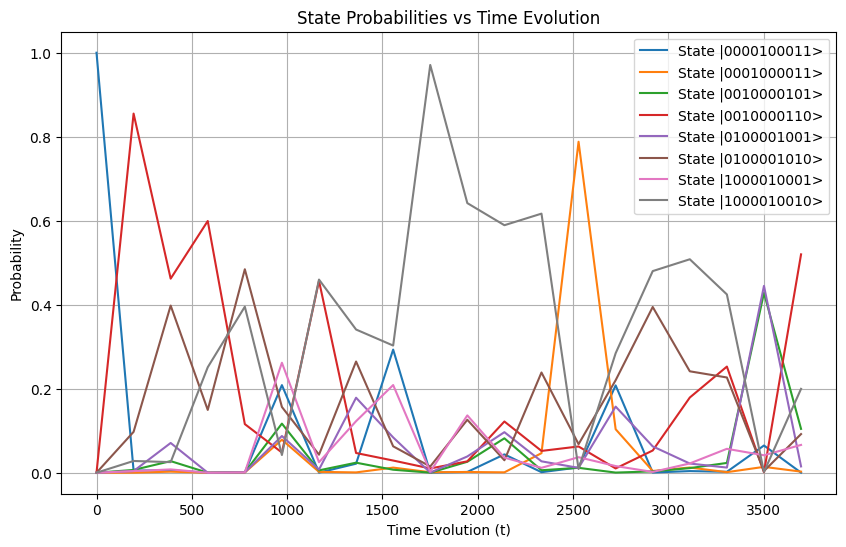

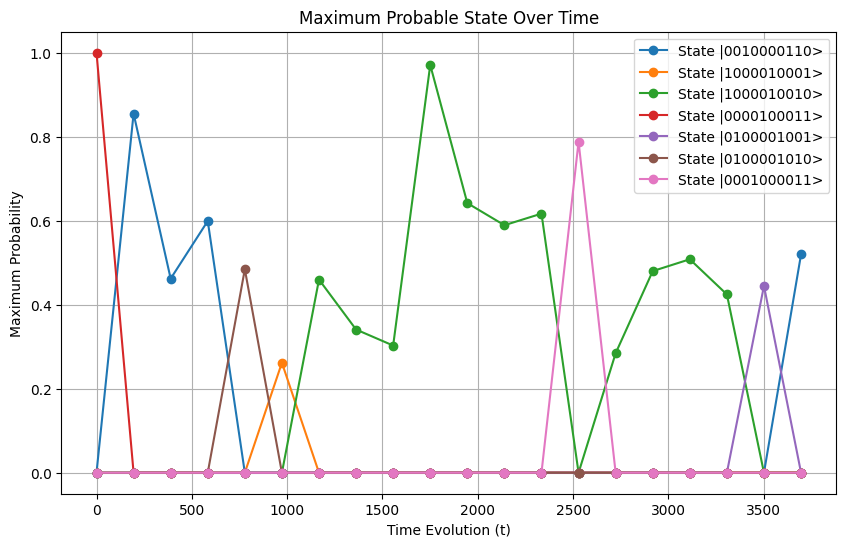

In [34]:

mapper = JordanWignerMapper()
hf_state = HartreeFock(
    electronic_structure_problem.num_spatial_orbitals,
    electronic_structure_problem.num_particles,
    mapper
)

# Step 3: Backend setup
backend = Aer.get_backend("qasm_simulator")

# Step 4: Loop over different time evolutions
state_probabilities = {}
max_probable_states = []  # To store maximum probable states at each time

for t in evolution_times:
    # Prepare circuit
    qc = QuantumCircuit(hf_state.num_qubits)
    qc.compose(hf_state, inplace=True)  # HF reference state
    evolution_op = PauliEvolutionGate(qubit_hamiltonian, time=t)
    qc.append(evolution_op, range(hf_state.num_qubits))  # Time evolution
    qc.measure_all()

    # Transpile and simulate
    tqc = transpile(qc, backend)
    result = backend.run(tqc, shots=shots).result()
    counts = result.get_counts()

    # Normalize counts to probabilities
    total_shots = sum(counts.values())
    probabilities = {state: count / total_shots for state, count in counts.items()}

    # Find the state with maximum probability
    max_state = max(probabilities, key=probabilities.get)
    max_probable_states.append((t, max_state, probabilities[max_state]))

    # Store probabilities for this time
    state_probabilities[t] = probabilities

# Step 5: Plotting all state probabilities over time
all_states = set()
for probs in state_probabilities.values():
    all_states.update(probs.keys())
all_states = sorted(all_states)

fig, ax = plt.subplots(figsize=(10, 6))
for state in all_states:
    probs_over_time = [state_probabilities[t].get(state, 0.0) for t in evolution_times]
    ax.plot(evolution_times, probs_over_time, label=f"State |{state}>")

ax.set_title("State Probabilities vs Time Evolution")
ax.set_xlabel("Time Evolution (t)")
ax.set_ylabel("Probability")
ax.legend()
plt.grid()
plt.show()

# Step 6: Plot the maximum probable state over time
times, states, max_probs = zip(*max_probable_states)
unique_states = list(set(states))  # List of all unique max probable states

fig, ax = plt.subplots(figsize=(10, 6))
for state in unique_states:
    state_probs = [
        max_probs[i] if states[i] == state else 0.0 for i in range(len(times))
    ]
    ax.plot(times, state_probs, marker='o', label=f"State |{state}>")

ax.set_title("Maximum Probable State Over Time")
ax.set_xlabel("Time Evolution (t)")
ax.set_ylabel("Maximum Probability")
ax.legend()
plt.grid()
plt.show()
